In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow tensorflow-addons matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Paths for test (used for training in this case) and test_degraded images
test_path = '/content/drive/MyDrive/DnCNN/test'    # Folder containing original test images
test_degraded_path = '/content/drive/MyDrive/DnCNN/test_LR_degraded'  # Folder containing degraded test images

In [ ]:
# Step 2: Function to load images
def load_images_from_folder(folder_path, target_size=(32, 32)):
    images = []
    for filename in sorted(os.listdir(folder_path)):  # Sort to maintain consistent order
        img_path = os.path.join(folder_path, filename)
        img = load_img(img_path, target_size=target_size)  # Load image and resize
        img = img_to_array(img).astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

In [ ]:
# Step 3: Load images
target_size = (128, 128)  # Change this based on your image resolution
x_train = load_images_from_folder(test_path, target_size=target_size)

x_train_noisy = load_images_from_folder(test_degraded_path, target_size=target_size)

# Check loaded image shapes
print(f"Training Original Images Shape: {x_train.shape}")
print(f"Training Degraded Images Shape: {x_train_noisy.shape}")

Training Original Images Shape: (80, 128, 128, 3)
Training Degraded Images Shape: (80, 128, 128, 3)


In [ ]:
# Step 4: Define the DnCNN Model
def dncnn(input_shape=(128, 128, 3), depth=20, filters=64, kernel_size=5):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters, kernel_size, padding='same', use_bias=False)(input_layer)
    x = Activation('relu')(x)
    for _ in range(depth - 2):
        x = Conv2D(filters, kernel_size, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = Conv2D(input_shape[-1], kernel_size, padding='same', use_bias=False)(x)
    output_layer = x - input_layer
    return Model(inputs=input_layer, outputs=output_layer)


# Instantiate the model
input_shape = x_train_noisy.shape[1:]
model = dncnn(input_shape=input_shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mse'])

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 128, 128, 64)   │          4,800 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 128, 128, 64)   │              0 │ conv2d_17[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 128, 128, 64)   │        102,400 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 128, 128, 64)   │            256 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │        102,400 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 128, 128, 64)   │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │        102,400 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 128, 128, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 64)   │        102,400 │ activation_19[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 128, 128, 64)   │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (Activation)         

 Total params: 1,857,408 (7.09 MB)

 Trainable params: 1,855,104 (7.08 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [ ]:
print("x_train shape:", x_train.shape)
print("x_train_noisy shape:", x_train_noisy.shape)
print("Min and Max values of x_train:", x_train.min(), x_train.max())
print("Min and Max values of x_train_noisy:", x_train_noisy.min(), x_train_noisy.max())

x_train shape: (80, 128, 128, 3)
x_train_noisy shape: (80, 128, 128, 3)
Min and Max values of x_train: 0.0 1.0
Min and Max values of x_train_noisy: 0.0 1.0


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, x_train_noisy, x_val_noisy = train_test_split(
    x_train, x_train_noisy, test_size=0.2, random_state=42
)

print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)


Training data shape: (51, 128, 128, 3)
Validation data shape: (13, 128, 128, 3)


In [ ]:
import tensorflow as tf  # Ensure TensorFlow is imported

# Define the checkpoint to save the best model
checkpoint = ModelCheckpoint(
    "dncnn_model_trained.keras", monitor='val_loss', save_best_only=True, verbose=1
)

# Explicitly define the loss function
def custom_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Recompile the model with a custom loss function
model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_mse, metrics=['mse'])

# Train the model without EarlyStopping
history = model.fit(
    x_train_noisy, x_train - x_train_noisy,  # Input is noisy images, target is the noise
    validation_data=(x_val_noisy, x_val - x_val_noisy),  # Validation data
    epochs=100,  # Train for a fixed number of epochs
    batch_size=16,  # Adjust as needed for memory
    verbose=2,  # Detailed logs for training
    callbacks=[checkpoint]  # Only checkpointing is enabled
)

# Print training history for additional insight
print("Training completed!")


Epoch 1/100

Epoch 1: val_loss improved from inf to 10697.82715, saving model to dncnn_model_trained.keras
4/4 - 19s - 5s/step - loss: 0.1670 - mse: 0.1670 - val_loss: 10697.8271 - val_mse: 10697.8271
Epoch 2/100

Epoch 2: val_loss did not improve from 10697.82715
4/4 - 1s - 371ms/step - loss: 0.1247 - mse: 0.1247 - val_loss: 1586967.2500 - val_mse: 1586967.3750
Epoch 3/100

Epoch 3: val_loss did not improve from 10697.82715
4/4 - 1s - 365ms/step - loss: 0.0735 - mse: 0.0735 - val_loss: 3306661.5000 - val_mse: 3306662.2500
Epoch 4/100

Epoch 4: val_loss did not improve from 10697.82715
4/4 - 1s - 366ms/step - loss: 0.0678 - mse: 0.0678 - val_loss: 11637787.0000 - val_mse: 11637786.0000
Epoch 5/100

Epoch 5: val_loss did not improve from 10697.82715
4/4 - 1s - 366ms/step - loss: 0.0412 - mse: 0.0412 - val_loss: 54139804.0000 - val_mse: 54139804.0000
Epoch 6/100

Epoch 6: val_loss did not improve from 10697.82715
4/4 - 1s - 366ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 5000047.0000

In [ ]:
checkpoint = ModelCheckpoint("dncnn_model_trained.keras", monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
model.load_weights("dncnn_model_trained.keras")
print("Model trained and weights loaded.")

Model trained and weights loaded.


In [ ]:
# Step 7: Denoise the training (test_degraded) images
train_denoised = x_train_noisy + model.predict(x_train_noisy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


In [ ]:
# Step 8: Display results
def display_images(original, noisy, denoised, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Original
        plt.subplot(3, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")
        # Noisy
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis("off")
        # Denoised
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i])
        plt.title("Denoised")
        plt.axis("off")
    plt.show()

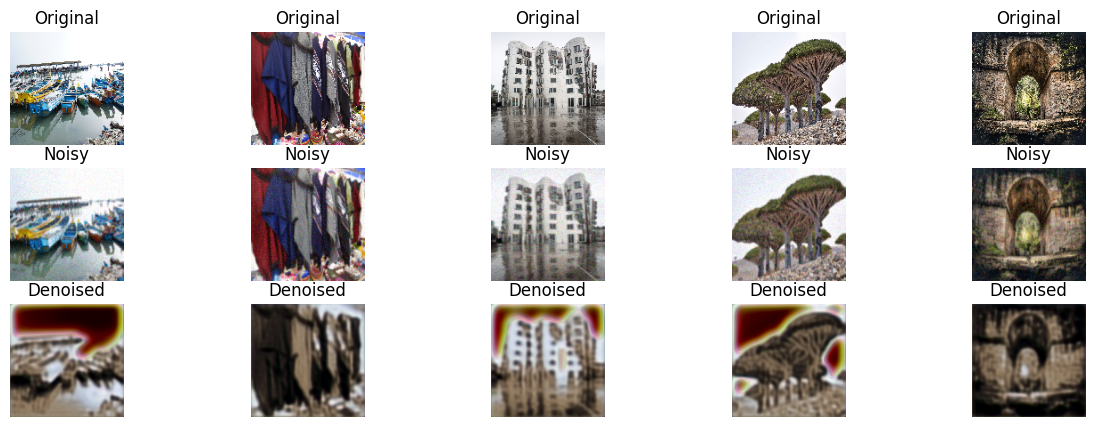

In [ ]:
# Display the first 5 images
display_images(x_train, x_train_noisy, train_denoised)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize lists to store the metrics for each image
psnr_values = []
ssim_values = []
mse_values = []

# Loop through each image in the test set
for i in range(len(x_val)):
    original = x_val[i]
    denoised = model.predict(np.expand_dims(x_val_noisy[i], axis=0))[0]  # Predict denoised image

    # Compute PSNR
    psnr_val = psnr(original, denoised, data_range=1)  # PSNR assumes images are normalized [0, 1]
    psnr_values.append(psnr_val)

    # Compute SSIM
    ssim_val = ssim(original, denoised, data_range=1, win_size=7, channel_axis=2)  # Specify channel_axis
    ssim_values.append(ssim_val)

    # Compute MSE
    mse_val = mean_squared_error(original.flatten(), denoised.flatten())
    mse_values.append(mse_val)

# Calculate average metrics
avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)
avg_mse = np.mean(mse_values)

# Print the results
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average MSE: {avg_mse:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average PSNR: 5.17 dB
Average SSIM: 0.0517
Average MSE: 0.345400
